In [96]:
from keras.metrics import mean_squared_error
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from typing import Tuple

In [97]:
# Constants
INPUT_FEATURES = 26                # Number of input features (e.g., temperature, humidity, etc.)
SEQUENCE_LEN = 7 * 24              # 7 days of hourly data
OUTPUT_LEN = 1 * 24                # 24 hours in the next day
OUTPUT_FEATURES = 3 * OUTPUT_LEN   # Predicting 3 features for each day
LSTM_UNITS = 128                   # Number of LSTM units
DENSE_UNITS = 128                  # Number of Dense layer units
DROPOUT_RATE = 0.2                 # Dropout rate

In [98]:
def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LEN - OUTPUT_LEN):
        X.append(data[i: i + SEQUENCE_LEN])
        y.append(data[i + SEQUENCE_LEN: i + SEQUENCE_LEN + OUTPUT_LEN, :3]) # Taking the first 3 features for the next 24 hours
    return np.array(X), np.array(y)


def invert_scale(data, scaler):
    copy_data = data.copy()
    for i in range(len(data)):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_data[:, i::3] = data[:, i::3] * std + mean
    return copy_data


def MSE(y_true, y_pred):
    T_mse = np.mean((y_true[:, 0::3] - y_pred[:, 0::3])**2, axis=0).reshape(1, -1)
    P_mse = np.mean((y_true[:, 1::3] - y_pred[:, 1::3])**2, axis=0).reshape(1, -1)
    R_mse = np.mean((y_true[:, 2::3] - y_pred[:, 2::3])**2, axis=0).reshape(1, -1)
    
    MSE_by_hour = np.append(np.append(T_mse, P_mse, axis=0), R_mse, axis=0)
    
    return MSE_by_hour, np.mean(MSE_by_hour, axis=1), np.mean(MSE_by_hour)


def plot_one_prediction(idx: int, X_true, y_true, y_pred, scaler, figsize: Tuple[int] = (15, 10)):
    x = range(SEQUENCE_LEN + OUTPUT_LEN)
    x1, x2 = x[1:1 + SEQUENCE_LEN], x[SEQUENCE_LEN:]
    labels = ['Temperature [C]', 'Pressure [hPa]', 'Rainfall [mm]']

    fig, axs = plt.subplots(3, figsize=figsize)
    fig.suptitle('Weather Forecast: Actual vs Predicted')
    for i in range(3):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        axs[i].plot(x1, X_true[idx + 1, :, i] * std + mean, label='Given data', color='green')
        axs[i].plot(x2, y_true[:, i::3][idx] * std + mean, label='Actual', color='blue')
        axs[i].plot(x2, y_pred[:, i::3][idx] * std + mean, label='Predicted', color='red')
        axs[i].set_ylabel(labels[i])
        axs[i].grid()
        axs[i].legend()
    axs[2].set_xlabel('Time (Hours)')
    plt.show()

In [15]:
data = pd.read_csv('../data/preprocessed_data/complete_krk_2017-22.csv')
data = data.drop('timestamp', axis=1)
cols = data.columns

In [16]:
# Assuming 'data' is your dataset with shape (total_hours, 26_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[-1.84487084,  0.96334401, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.85603007,  0.93829589, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.52125303,  0.85062749, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       ...,
       [-0.14866714,  0.43733359, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.04823402,  0.43733359, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.40532954,  0.42480953, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282]])

In [17]:
# Create sequences
X, y = create_sequences(data_normalized)

In [18]:
train_size = 24 * (365 * 3 + 366)
val_size = 24 * 365

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [19]:
# Define the model
model = Sequential()

# LSTM layers
model.add(LSTM(LSTM_UNITS, return_sequences=True, input_shape=(SEQUENCE_LEN, INPUT_FEATURES)))
model.add(LSTM(LSTM_UNITS, return_sequences=False))
# Dropout layer to prevent overfitting
model.add(Dropout(DROPOUT_RATE))
# Dense layers
model.add(Dense(DENSE_UNITS, activation='sigmoid'))
# Output layer
model.add(Dense(OUTPUT_FEATURES, activation='linear'))  # 'linear' activation for regression tasks
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          79360     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 72)                9288      
                                                                 
Total params: 236744 (924.78 KB)
Trainable params: 236744 (924.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
1147/1147 [==============================] - 330s 285ms/step - loss: 0.4547 - val_loss: 0.4269
Epoch 2/20
1147/1147 [==============================] - 336s 293ms/step - loss: 0.3956 - val_loss: 0.4512
Epoch 3/20
1147/1147 [==============================] - 344s 300ms/step - loss: 0.3570 - val_loss: 0.4569
Epoch 4/20
1147/1147 [==============================] - 347s 303ms/step - loss: 0.3295 - val_loss: 0.4777
Epoch 5/20
1147/1147 [==============================] - 342s 298ms/step - loss: 0.3093 - val_loss: 0.4860
Epoch 6/20
1147/1147 [==============================] - 346s 301ms/step - loss: 0.2963 - val_loss: 0.5085
Epoch 7/20
1147/1147 [==============================] - 345s 301ms/step - loss: 0.2850 - val_loss: 0.4931
Epoch 8/20
1147/1147 [==============================] - 351s 306ms/step - loss: 0.2776 - val_loss: 0.5049
Epoch 9/20
1147/1147 [==============================] - 341s 298ms/step - loss: 0.2689 - val_loss: 0.5089
Epoch 10/20
1147/1147 [=======================

In [9]:
model.save('LSTM_27-12-2023_improved')

INFO:tensorflow:Assets written to: LSTM_27-12-2023_improved\assets


INFO:tensorflow:Assets written to: LSTM_27-12-2023_improved\assets


In [20]:
from keras.models import load_model

model = load_model('LSTM_27-12-2023_improved')
history = model.history

In [21]:
loss = history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [22]:
predictions = model.predict(X_val)

# Calculate MSE
mse = mean_squared_error(y_val, predictions).numpy()
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

274/274 [==============================] - 29s 103ms/step
Mean Squared Error (MSE): [0.01069763 0.01151807 0.01047315 ... 0.05362409 0.05417611 0.06623261]
Root Mean Squared Error (RMSE): [0.10342936 0.10732226 0.10233841 ... 0.23156875 0.23275761 0.25735697]


In [24]:
# Make predictions
y_pred = model.predict(X_test)

268/268 [==============================] - 26s 99ms/step


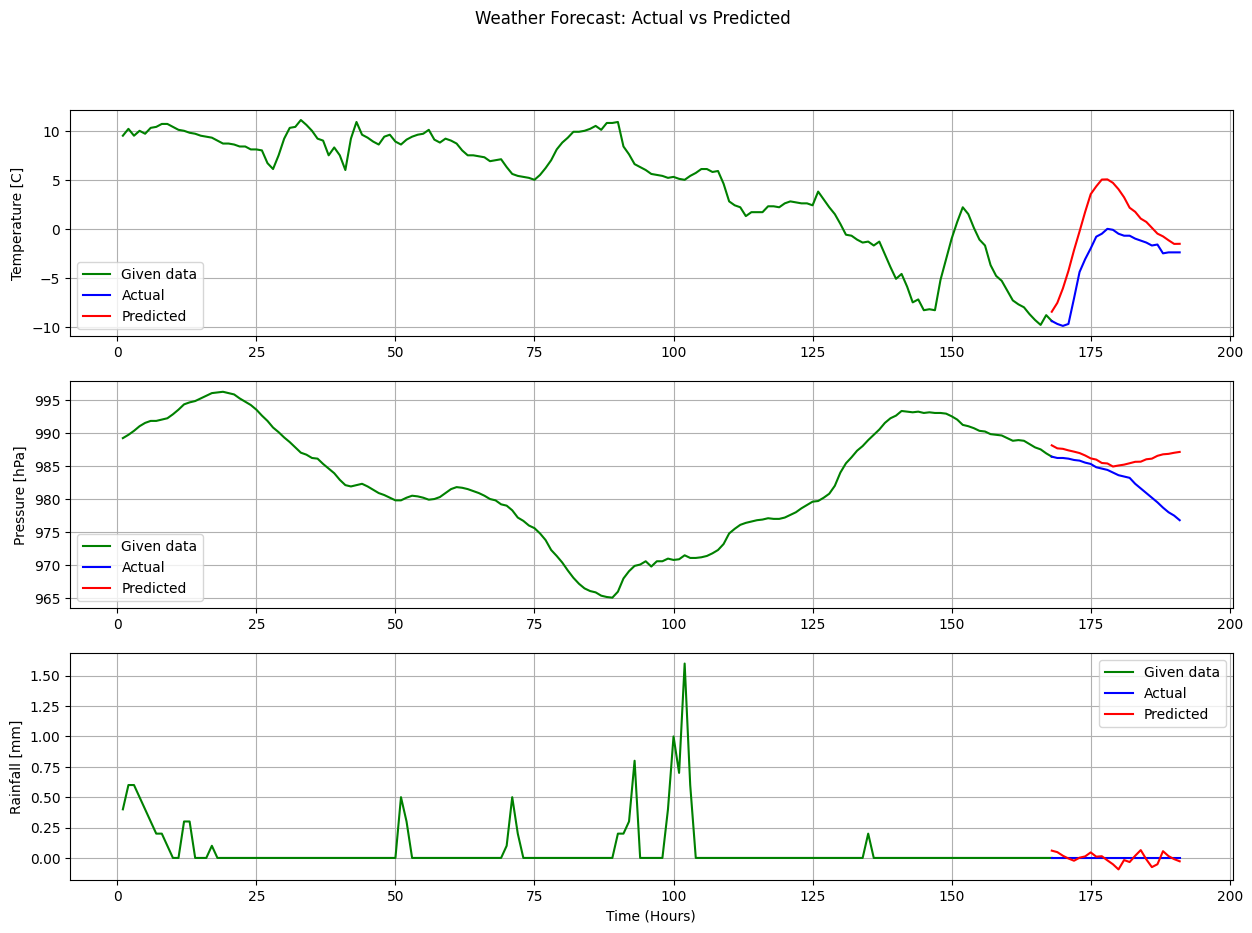

In [100]:
plot_one_prediction(4, X_test, y_test, y_pred, scaler)

array([[-2.0568963 ,  0.02403969, -0.13402178, ..., -1.26459062,
        -1.07807737, -0.13402178],
       [-2.12385171, -0.03858059, -0.13402178, ..., -1.36502374,
        -1.17826983, -0.13402178],
       [-2.17964789, -0.07615277, -0.13402178, ..., -1.3538645 ,
        -1.26593823, -0.13402178],
       ...,
       [-1.25343139,  0.27452084, -0.13402178, ..., -0.07055249,
         0.41228548, -0.13402178],
       [-1.28690909,  0.23694867, -0.13402178, ..., -0.14866714,
         0.43733359, -0.13402178],
       [-1.08604287,  0.17432838, -0.13402178, ..., -0.04823402,
         0.43733359, -0.13402178]])

In [76]:
MSE(invert_scale(y_test, scaler), invert_scale(y_pred, scaler))[1]

array([ 9.66, 19.29,  0.31])